In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
raw_communities = pd.read_csv('../Data/communities.csv')
raw_egm = pd.read_csv("../Data/EGM.csv")
raw_houses = pd.read_csv("../Data/Houses-by-suburb.csv")
raw_all_offences = pd.read_excel("../Data/LGA_Offences.xlsx", sheet_name=None)
raw_offense = raw_all_offences['Table 01']

In [3]:
raw_offense = raw_all_offences['Table 01']

In [4]:
from bs4 import BeautifulSoup
import requests

url = "https://www.vec.vic.gov.au/electoral-boundaries/local-councils"
doc = requests.get(url).text

In [5]:
soup = BeautifulSoup(doc, 'html.parser')
base = soup.find('h3', string='A')

def clean_lga(lga: str):
    lga = lga.strip().lower()
    lga = lga.replace('-', ' ')

    replaces = {
        'moreland': 'merribek'
    }
    lga = ''.join([replaces.get(word, word) for word in lga.split() if word not in ['of', 'city', 'rural', 'shire', 'borough']])

    return lga

lgas = []
for link in base.find_all_next('a'):
    text = link.text.strip()
    if text == '':
        continue
    
    lgas.append(clean_lga(' '.join(text.split(' ')[:-1]).lower()))
    if text == 'Yarriambiack Shire Council':
        break

lgas = np.unique(lgas)

@np.vectorize
def islga(name):
    for t in lgas:
        if name in t:
            return True
        
    return False

lgas[:5]

array(['alpine', 'ararat', 'ballarat', 'banyule', 'basscoast'],
      dtype='<U19')

In [11]:
import re

# clean egm
def clean_egm(egm):
    print("CLEANING EGM")
    egm = egm.copy()
    egm = egm.iloc[:57, :]

    egm['LGA'] = egm['LGA Name'].apply(clean_lga)
    egm = egm.drop(['LGA Name'], axis=1)


    # filter only the ones in lgas
    old = pd.unique(egm['LGA'])
    egm = egm.query('@islga(LGA)')
    n = pd.unique(egm['LGA'])

    print(f"removed {np.setdiff1d(old, n)}")
    print(f"{n.size} LGAs")

    display(egm.head())

    return egm


def clean_offenses(crime):
    print('CLEANING OFFENSES')
    crime = crime.copy()
    crime = crime[crime['Local Government Area'] != 'Total']
    crime['LGA'] = crime['Local Government Area'].apply(lambda s: clean_lga(s.lower().strip()))
    crime = crime.drop(['Local Government Area'], axis=1)

    # filter only the ones in lgas
    old = pd.unique(crime['LGA'])
    crime = crime.query('@islga(LGA)')
    n = pd.unique(crime['LGA'])

    print(f"removed {np.setdiff1d(old, n)}")
    print(f"{n.size} LGAs")
    display(crime.head())
    return crime

def clean_community(community):
    print('CLEANING COMMUNITY')
    community: pd.DataFrame = community.copy()

    community['LGA'] = community['LGA'].apply(lambda s: "none" if (out := re.search(r"(.*) \(\w+\)", s.strip())) is None else out.group(1))
    community = community[community['LGA'] != "none"]
    community['LGA'] = community['LGA'].apply(clean_lga)

    # aggregate over numeric and categorical
    numerics = set(community.select_dtypes([np.number]).columns)
    categorical = set(community.columns) - numerics
    cat = {
        col: pd.Series.mode for col in categorical if col != 'LGA'
    }
    num = {
        col: pd.Series.sum for col in numerics
    }

    # fix percentages
    numper = [
        col for col in numerics if '%' in col or 'weighted' in col
    ]

    # create population and scale
    population = community['Population Density'] * community['Area (km^2)']
    community['Population'] = population
    community[numper] = community[numper].multiply(population, axis='index')

    # aggergate
    community = community.groupby("LGA").agg({**cat, **num, 'Population': pd.Series.sum})
    
    # rescale population
    community['Population Density'] = community['Population'] / community['Area (km^2)']
    community[numper] = community[numper].divide(community['Population'], axis='index')

    display(community.head(2))
    print(f"unique LGAs {community.shape[0]}")
    return community


def clear_region(region):
    region = region.strip().lower()

    try:
        if '(' in region and ')' in region:
            region = re.search(r"(.*) \([\w\s]+\)", region).group(1)
    except Exception as e:
        print(region)
        raise e
    
    return region

def clean_houses(communities, houses):
    print('CLEANING HOUSES')
    community = communities.copy()

    community['Locality'] = community['Community Name'].apply(clear_region)
    houses['Locality'] = houses['Locality'].apply(clear_region)
    houses = houses.set_index('Locality')

    # clear na and - drops, impute data
    houses = houses.dropna()
    houses = houses[~houses.isin(['-']).any(axis=1)]
    houses = houses.apply(pd.to_numeric)

    houses.rename(columns=lambda c: c + ' weighted', inplace=True)

    print(f'Rows before {community.shape[0]}')

    # join houses into community, TODO: this might repeat them?
    community = community.join(houses, on='Locality', how='inner')

    print(f'Rows after {community.shape[0]}')
    display(community.head(2))

    return community


print(f'total LGAs {len(lgas)}')
offense = clean_offenses(raw_offense)
egm = clean_egm(raw_egm)
# community = clean_houses(raw_communities, raw_houses)
# community = clean_community(community)


total LGAs 79
CLEANING OFFENSES
removed ['justiceinstitutionsandimmigrationfacilities' 'unincorporatedvic']
79 LGAs


,Year,Year ending,Police Region,Offence Count,"Rate per 100,000 population",LGA
0,2023,December,1 North West Metro,8072,6256.318199,banyule
1,2023,December,1 North West Metro,17044,8666.589574,brimbank
2,2023,December,1 North West Metro,13715,8823.868581,darebin
3,2023,December,1 North West Metro,5720,6143.155350,hobsonsbay
4,2023,December,1 North West Metro,18342,7030.782116,hume


CLEANING EGM
removed []
57 LGAs


,Region,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,LGA
0,M,1.095429e+08,1.115836e+08,1.010001e+08,1.035006e+08,1.091612e+08,1.116516e+08,1.152932e+08,1.184756e+08,1.207063e+08,91066518.95,whittlesea
1,C,1.071793e+07,1.121941e+07,1.014142e+07,1.035065e+07,1.003788e+07,9.050693e+06,9.105582e+06,9.720508e+06,9.200584e+06,7004272.36,northerngrampians
2,C,1.184686e+08,1.183161e+08,1.097196e+08,1.116281e+08,1.130210e+08,1.132050e+08,1.154188e+08,1.188324e+08,1.203854e+08,89137264.73,greatergeelong
3,C,1.105642e+07,1.091608e+07,1.019461e+07,1.007489e+07,1.026330e+07,1.016289e+07,1.023095e+07,1.024279e+07,1.075162e+07,8316806.76,colacotway
4,C,1.083741e+07,1.116534e+07,1.054645e+07,1.030988e+07,1.057564e+07,1.061337e+07,1.139579e+07,1.196206e+07,1.234074e+07,9631820.68,moorabool


In [10]:
import sqlite3

def to_db(df: pd.DataFrame, name):
    cnx = sqlite3.connect('./data.sqlite3')
    df.to_sql(name=name, con=cnx, if_exists='replace')
    cnx.close()


to_db(offense, 'offense')
to_db(egm, 'egm')

# todo: do this for community too


In [275]:
print(f"community/housing size {community.shape[0]}")
print(f"crime size {offense['LGA'].unique().shape[0]}")
print(f"egm size {egm.shape[0]}")

community/housing size 78
crime size 79
egm size 57


''

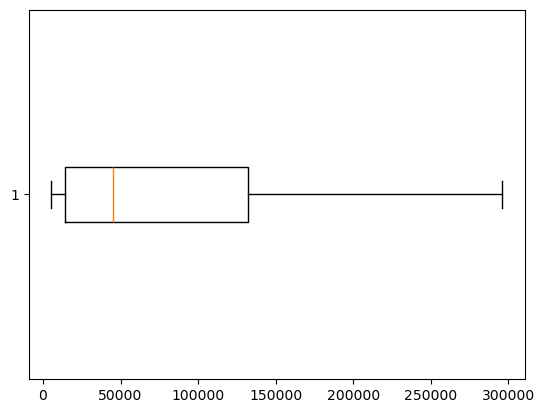

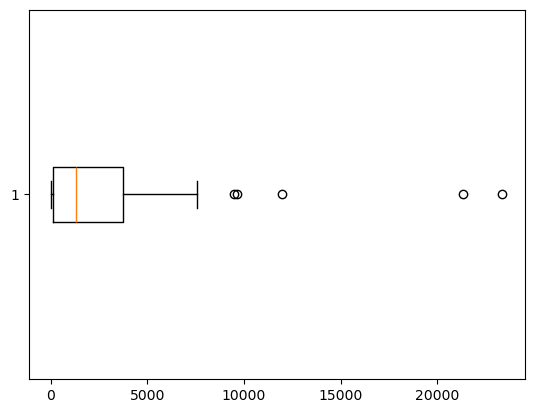

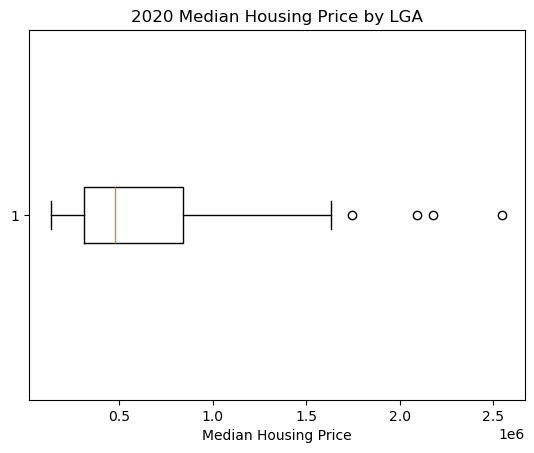

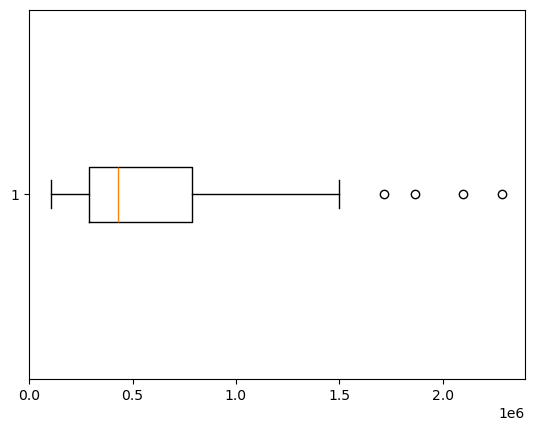

In [277]:
plt.figure()
plt.boxplot(community['Population'], vert=False)
plt.figure()
plt.boxplot(community['Area (km^2)'], vert=False)

plt.figure()
plt.boxplot(community['2020 weighted'], vert=False)
plt.xlabel('Median Housing Price')
plt.title('2020 Median Housing Price by LGA')

plt.figure()
plt.boxplot(community['2019 weighted'], vert=False)


In [200]:
list(communities.columns)

['Aboriginal or Torres Strait Islander, persons',
 '3rd top language spoken',
 'Volunteers, persons',
 'Obstetric type separations, 2012-13',
 'Community Name',
 'Born overseas, persons',
 '2nd top language spoken',
 'Grid reference',
 'Top language spoken, persons',
 'Male-headed lone parent families',
 'Primary school students',
 'Dwellings with no internet',
 'Top language spoken',
 '2nd top language spoken, persons',
 'Poor English proficiency, persons',
 '2nd top industry - persons',
 'Location',
 'Region',
 '4th top language spoken, persons',
 'Public Housing Dwellings',
 'Dwellings with no motor vehicle',
 'Requires assistance with core activities, persons',
 'Unpaid carer to person with disability, persons',
 'Holds degree or higher, persons',
 '3rd top industry - persons',
 'Number of families',
 '2nd top country of birth',
 '4th top country of birth',
 'TAFE students',
 'ABS remoteness category',
 '4th top language spoken',
 'Top occupation',
 'Top country of birth',
 '3rd to

In [185]:
re.search(r"(.*) \(\w+\)", "Yarra (c)").group(1)

'Yarra'

In [170]:
print('2024 |', ' '.join(sorted(lgas)))
print('egm |', ' '.join(sorted(egm['LGA'].unique())))
print('offense |', ' '.join(sorted(offense['LGA'].unique())))
print(np.setdiff1d(lgas, egm['LGA'].unique()))

2024 | alpine ararat ballarat banyule basscoast bawbaw bayside benalla boroondara brimbank buloke campaspe cardinia casey centralgoldfields colacotway corangamite darebin eastgippsland frankston gannawarra gleneira glenelg goldenplains greaterbendigo greaterdandenong greatergeelong greatershepparton hepburn hindmarsh hobsonsbay horsham hume indigo kingston knox latrobe loddon macedonranges manningham mansfield maribyrnong maroondah melbourne melton merribek mildura mitchell moira monash mooneevalley moorabool morningtonpeninsula mountalexander moyne murrindindi nillumbik northerngrampians portphillip pyrenees queenscliffe southerngrampians southgippsland stonnington strathbogie surfcoast swanhill towong wangaratta warrnambool wellington westwimmera whitehorse whittlesea wodonga wyndham yarra yarraranges yarriambiack
egm | alpine ballarat banyule basscoast bawbaw bayside benalla boroondara brimbank campaspe cardinia casey centralgoldfields colacotway darebin eastgippsland frankston glen

<Axes: xlabel='Year'>

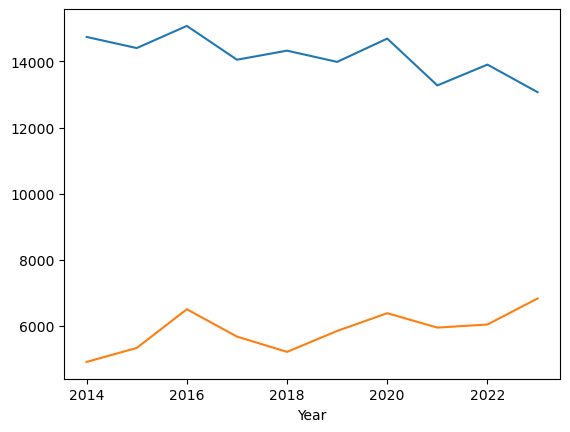

In [61]:
crime = lga['Table 01']
crime = crime[crime['Local Government Area'] != 'Total']
crime = crime.copy()
crime['LGA'] = crime['Local Government Area'].apply(lambda s: s.lower().strip())
crime.head()


yarra = crime[crime['LGA'] == 'yarra']
yarra = yarra.set_index('Year')
yarra['Rate per 100,000 population'].plot()

monash = crime[crime['LGA'] == 'monash']
monash = monash.set_index('Year')
monash['Rate per 100,000 population'].plot()

In [75]:
egm['LGA'] = egm['LGA Name'].apply(lambda s: s.lower())
egm["LGA"]

0                city of whittlesea
1       shire of northern grampians
2           city of greater geelong
3              shire of colac-otway
4                shire of moorabool
5       shire of central goldfields
6                 shire of mitchell
7                   shire of alpine
8             rural city of benalla
9                 shire of campaspe
10                 shire of glenelg
11              shire of wellington
12            rural city of wodonga
13              city of warrnambool
14          city of greater bendigo
15                 city of ballarat
16          rural city of swan hill
17       city of greater shepparton
18            rural city of mildura
19          shire of east gippsland
20              shire of bass coast
21                  city of latrobe
22              shire of surf coast
23         shire of south gippsland
24          shire of macedon ranges
25            rural city of horsham
26                 shire of baw baw
27         rural city of wan